# Unit 12 - Tales from the Crypto

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin and Ethereum and create a DataFrame of sentiment scores for each coin.

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [232]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re
from collections import Counter
from nltk import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
import spacy
from spacy import displacy
from newsapi import NewsApiClient
from path import Path
import csv
nltk.download('vader_lexicon')
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = [20.0, 10.0]
%matplotlib inline



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sameerlakhe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [233]:
# Read your api key environment variable
load_dotenv()
api_key = os.getenv("NEWS_API_KEY")

In [234]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

# Function to create a dataframe for english news and french news
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

#this function writes the event data to a csv file to avoid calling the API multiple times
# for the same date range
#def write_csv(data, file_name):
   # with open(file_name, mode='w', encoding='utf-8', newline='\n') as csv_file:
       # writer = csv.DictWriter(csv_file, fieldnames = data[0].keys())

        #writer.writeheader()
        #for event in data:
            #writer.writerow(event)
            
def write_csv(df,file_name):
    file_path = Path(file_name)
    df.to_csv(file_path, index=False, encoding='utf-8-sig')

def get_news(query,language,file_name):
    complete_file_name = "./Resources/"+file_name
    path = Path(complete_file_name)
    if path.exists():
        print(f'The file {complete_file_name} exists')
        news_df = pd.read_csv(complete_file_name)
    else:
        print(f'retreiving data from new API for query: {query}, and language:{language}')
        results = newsapi.get_everything(
                    q=query,
                    language=language
                )
        print(f'total results for query "{query}" in langyage:{language} are : {results["totalResults"]}')
        #convert the news articles to dataframe
        news_df = create_df(results["articles"], language)
        write_csv(news_df,complete_file_name)
    return news_df
    

In [235]:
bitcoin_news_en_df = get_news("bitcoin and 2022","en","Bitcoin2022_en.csv")
bitcoin_news_en_df.head()

bitcoin_news_fr_df = get_news("bitcoin and 2022","fr","Bitcoin2022_fr.csv")
bitcoin_news_fr_df.head()

The file ./Resources/Bitcoin2022_en.csv exists
The file ./Resources/Bitcoin2022_fr.csv exists


,title,description,text,date,language
0,The Problem with Bitcoin Miners,Comments,Disclosure: I hold short positions in companie...,2022-05-15,fr
1,"L’âge d’or du cinéma n’est plus, place à l’âge...",L’une des plus grandes chaînes de salles de ci...,"AMC peut remercier les boursicoteurs, qui lui ...",2022-04-19,fr
2,"Dans le plus grand secret, Snowden a créé une ...",Réfugié en Russie depuis qu'il a reconnu être ...,"Edward Snowden, ancien employé de la CIA, sort...",2022-04-28,fr
3,"Ne vous tatouez pas votre crypto préférée, vou...",Ce milliardaire américain a eu la mauvaise idé...,Mike Novogratz est l’une des figures emblémati...,2022-05-15,fr
4,Le bitcoin perd ses gains de 2022 et passe sou...,"Londres - Le bitcoin, la principale cryptomonn...","A 29.764 dollars, son plus bas mardi, le bitco...",2022-05-10,fr


In [236]:
# Create the Bitcoin sentiment scores DataFrame
# Create a DataFrame with the news in English
#bitcoin_news_en_df = create_df(bitcoin_news_en["articles"], "en")
# Create a DataFrame with the news in French
#bitcoin_news_fr_df = create_df(bitcoin_news_fr["articles"], "fr")
#concat to get dataframe with news in english and french
bitcoin_news_all_df =pd.concat([bitcoin_news_en_df, bitcoin_news_fr_df])  
bitcoin_news_all_df.reset_index()
bitcoin_news_all_df.head()
# Save to CSV, read the CSV to get the data as there is limit for calling news API multiple times in day
#file_path = Path("./Resources/bitcoin_news_en_fr.csv")
#bitcoin_news_all_df.to_csv(file_path, index=False, encoding='utf-8-sig')

,title,description,text,date,language
0,Why fossil fuel companies see green in Bitcoin...,ExxonMobil and other fossil fuel companies hav...,A Bitcoin mining site powered by otherwise los...,2022-05-04,en
1,What is Blockchain: Everything You Need to Kno...,<table><tr><td></td></tr><tr><td></td></tr>\r\...,"If you want to pay online, you need to registe...",2022-04-18,en
2,Bitcoin value drops by 50% since November peak,The slide in the value of cryptocurrencies com...,"Image source, Getty Images\r\nThe value of Bit...",2022-05-09,en
3,Factbox: U.S. companies and their cryptocurren...,A meltdown in one of the world's largest stabl...,May 12 (Reuters) - A meltdown in one of the wo...,2022-05-12,en
4,The Top 12 Blockchain Speakers for 2022,What’s happening in the blockchain industry th...,Whats happening in the blockchain industry thi...,2022-04-26,en


In [237]:
# Fetch the Ethereum news articles
ethereum_news_en_df = get_news("ethereum and 2022","en","Ethereum2022_en.csv")
# Show the total number of news
#ethereum_news_en_df.head()

ethereum_news_fr_df = get_news("ethereum and 2022","fr","Ethereum2022_fr.csv")
# Show the total number of news
#ethereum_news_fr_df.head()
ethereum_news_all_df =pd.concat([ethereum_news_en_df, ethereum_news_fr_df])  
ethereum_news_all_df.reset_index()
ethereum_news_all_df.head()

The file ./Resources/Ethereum2022_en.csv exists
The file ./Resources/Ethereum2022_fr.csv exists


,title,description,text,date,language
0,What is Blockchain: Everything You Need to Kno...,<table><tr><td></td></tr><tr><td></td></tr>\r\...,"If you want to pay online, you need to registe...",2022-04-18,en
1,How Bored Ape Yacht Club Broke Ethereum - CNET,"Transactions stalled for hours, and people pai...",When Bored Ape Yacht Club creators Yuga Labs a...,2022-05-04,en
2,Yuga Labs apologises after sale of virtual lan...,Demand for plots of land in multiplayer game O...,A multi-billion dollar cryptocurrency company ...,2022-05-02,en
3,What is the Ethereum merge and how could it ma...,Ethereum is preparing for an upgrade that’s be...,Ethereum is preparing for an upgrade thats bee...,2022-04-26,en
4,Ethereum and Bitcoin Prices Are Tanking. Here’...,<ol><li>Ethereum and Bitcoin Prices Are Tankin...,Editorial IndependenceWe want to help you make...,2022-05-09,en


In [238]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

# Sentiment scores dictionaries
title_sent = {
        "title_compound": [],
        "title_pos": [],
        "title_neu": [],
        "title_neg": [],
        "title_sent": [],
    }
text_sent = {
        "text_compound": [],
        "text_pos": [],
        "text_neu": [],
        "text_neg": [],
        "text_sent": [],
        }

analyzer = SentimentIntensityAnalyzer()
# Get sentiment for the text and the title
def get_sentiment_score(news_df):
    
    for index, row in news_df.iterrows():
        try:
            # Sentiment scoring with VADER
            title_sentiment = analyzer.polarity_scores(row["title"])
            title_sent["title_compound"].append(title_sentiment["compound"])
            title_sent["title_pos"].append(title_sentiment["pos"])
            title_sent["title_neu"].append(title_sentiment["neu"])
            title_sent["title_neg"].append(title_sentiment["neg"])
            title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

            text_sentiment = analyzer.polarity_scores(row["text"])
            text_sent["text_compound"].append(text_sentiment["compound"])
            text_sent["text_pos"].append(text_sentiment["pos"])
            text_sent["text_neu"].append(text_sentiment["neu"])
            text_sent["text_neg"].append(text_sentiment["neg"])
            text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
        except AttributeError:
            pass
        
    return title_sent,text_sent

title_sent,text_sent = get_sentiment_score(bitcoin_news_all_df)
    
# Attaching sentiment columns to the News DataFrame

bitcoin_title_sentiment_df = pd.DataFrame(title_sent)
bitcoin_text_sentiment_df = pd.DataFrame(text_sent)

#bitcoin_title_sentiment_df
#bitcoin_text_sentiment_df
print(bitcoin_title_sentiment_df.head())
print(bitcoin_text_sentiment_df.head())
#print(title_sent)
#bitcoin_news_all_df = bitcoin_news_all_df.join(bitcoin_title_sentiment_df).join(bitcoin_text_sentiment_df)

#bitcoin_news_all_df.head()
bitcoin_news_all_df = bitcoin_news_all_df.join(bitcoin_title_sentiment_df).join(bitcoin_text_sentiment_df)

   title_compound  title_pos  title_neu  title_neg  title_sent
0          0.0000      0.000      1.000        0.0           0
1          0.0000      0.000      1.000        0.0           0
2          0.3400      0.255      0.745        0.0           1
3          0.0000      0.000      1.000        0.0           0
4          0.2023      0.231      0.769        0.0           1
   text_compound  text_pos  text_neu  text_neg  text_sent
0        -0.0516     0.056     0.882     0.061         -1
1         0.5719     0.157     0.775     0.068          1
2         0.3400     0.072     0.928     0.000          1
3         0.3400     0.074     0.926     0.000          1
4         0.0000     0.000     1.000     0.000          0


In [239]:
# Create the Ethereum sentiment scores DataFrame
title_sent,text_sent = get_sentiment_score(ethereum_news_all_df)
    
# Attaching sentiment columns to the News DataFrame
ethereum_title_sentiment_df = pd.DataFrame(title_sent)
ethereum_text_sentiment_df = pd.DataFrame(text_sent)

print(ethereum_title_sentiment_df.head())
print(ethereum_text_sentiment_df.head())

ethereum_news_all_df = ethereum_news_all_df.join(ethereum_title_sentiment_df).join(ethereum_text_sentiment_df)


def get_scores(df,coin_name):
    coin_scores={}
    max_coin_title_compound_score = df["title_compound"].max()
    coin_scores['max_coin_title_compound_score'] = max_coin_title_compound_score
    
    max_coin_text_compound_score = df["text_compound"].max()
    coin_scores['max_coin_text_compound_score'] = max_coin_text_compound_score
    
    max_coin_title_positive_score = df["title_pos"].max()
    coin_scores['max_coin_title_positive_score'] = max_coin_title_positive_score
    
    max_coin_text_positive_score = df["text_pos"].max()
    coin_scores['max_coin_text_positive_score'] = max_coin_text_positive_score
    
    mean_coin_title_positive_score = df["title_pos"].mean()
    coin_scores['mean_coin_title_positive_score'] = mean_coin_title_positive_score
    
    mean_coin_text_positive_score = df["text_pos"].mean()
    coin_scores['mean_coin_text_positive_score'] = mean_coin_text_positive_score
    
    return coin_scores



   title_compound  title_pos  title_neu  title_neg  title_sent
0          0.0000      0.000      1.000        0.0           0
1          0.0000      0.000      1.000        0.0           0
2          0.3400      0.255      0.745        0.0           1
3          0.0000      0.000      1.000        0.0           0
4          0.2023      0.231      0.769        0.0           1
   text_compound  text_pos  text_neu  text_neg  text_sent
0        -0.0516     0.056     0.882     0.061         -1
1         0.5719     0.157     0.775     0.068          1
2         0.3400     0.072     0.928     0.000          1
3         0.3400     0.074     0.926     0.000          1
4         0.0000     0.000     1.000     0.000          0


<AxesSubplot:title={'center':'Bitcoin Title and Text Sentiment Comparisson'}>

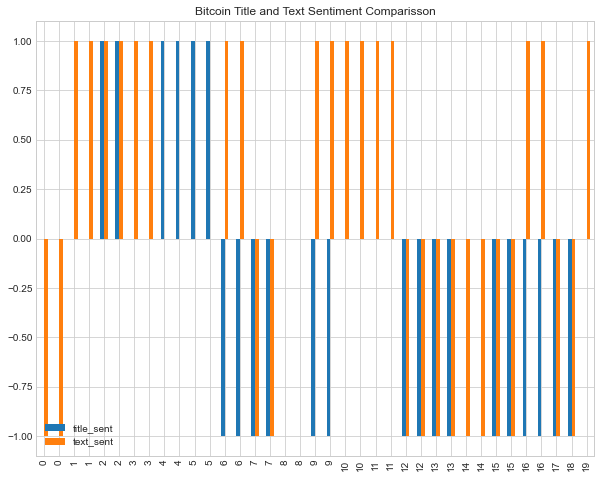

In [240]:
# Describe the Bitcoin Sentiment
# Plot bar chart
bitcoin_news_all_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="Bitcoin Title and Text Sentiment Comparisson",
    figsize=(10, 8),
    grid=True,
)

***The above bitcoin title and text sentiment chart indicates that the bitcoin sentiment changed to bearish recently***

<AxesSubplot:title={'center':'Ethereum Title and Text Sentiment Comparisson'}>

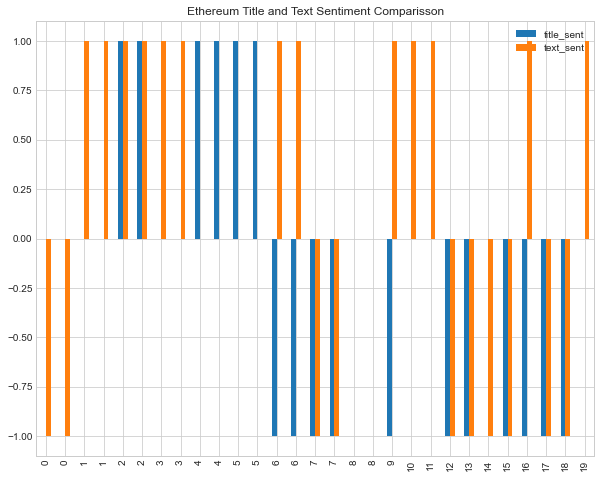

In [241]:
# Describe the Ethereum Sentiment
# Plot bar chart
ethereum_news_all_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="Ethereum Title and Text Sentiment Comparisson",
    figsize=(10, 8),
    grid=True,
)

In [248]:
bitcoin_scores = get_scores(bitcoin_news_all_df,'bitcoin')
#print(bitcoin_scores)
#bitcoin_scores_df = pd.DataFrame.from_dict(bitcoin_scores)
#bitcoin_scores_df.head()

eth_scores = get_scores(ethereum_news_all_df,'ethereium')
#print(eth_scores)

coin_scores={}
coin_scores['bitcoin']=bitcoin_scores
coin_scores['ethereum']=eth_scores

coin_scores_df = pd.DataFrame.from_dict(coin_scores)
coin_scores_df

,bitcoin,ethereum
max_coin_title_compound_score,0.340000,0.340000
max_coin_text_compound_score,0.865500,0.865500
max_coin_title_positive_score,0.255000,0.255000
max_coin_text_positive_score,0.263000,0.263000
mean_coin_title_positive_score,0.056243,0.068103
mean_coin_text_positive_score,0.072784,0.066862


***The above ethereum title and text sentiment chart indicates that the ethereum sentiment changed to bearish recently***

### Questions:

Q: Which coin had the highest mean positive score?

A: ***As per the mean positive scores for title is higher for ethereum, where mean positive score for text is higher for bitcoin***

Q: Which coin had the highest compound score?

A: ***As per the mean positive scores for title and text, both bitcoin and ethereium have same  compound score***

Q. Which coin had the highest positive score?

A: ***As per the mean positive scores for title and text, both bitcoin and ethereium have same highest positive score***

***In general, as per the latest news from 2022, the sentiment analysis for both coin is highly corelated***

---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [189]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw_en = set(stopwords.words('english'))
sw_fr = set(stopwords.words('french'))
# Expand the default stopwords list if necessary
#The news articles from english and french are combines
sw = sw_en.join(sw_fr)

In [201]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
    # Convert the words to lowercase
    # Remove the stop words
    tokens = [word.lower() for word in lem if word.lower() not in sw]
    return tokens

big_string = ' '.join(bitcoin_news_all_df["text"][0])
#print(big_string)

tokens = tokenizer(big_string)
print(tokens)

['bitcoin', 'mining', 'site', 'powered', 'otherwise', 'lost', 'gas', 'oil', 'well', 'near', 'linden', 'texas', 'april', 'th', 'photo', 'francois', 'picardafp', 'via', 'getty', 'images', 'corporate', 'climate', 'hype', 'fl', 'char', 'disclosure', 'hold', 'short', 'position', 'company', 'mentioned', 'article', 'financial', 'advicesix', 'month', 'ago', 'wrotebitcoin', 'miner', 'burn', 'enormous', 'amount', 'capital', 'capture', 'char']


In [199]:
# Create a new tokens column for Bitcoin
def generate_tokens(df):
    list_tokens=[]
    for row in df["text"]:
        tokens = tokenizer(row)
        list_tokens.append(tokens)
    return list_tokens

bitcoin_tokens = generate_tokens(bitcoin_news_all_df)
bitcoin_news_all_df['tokens'] = bitcoin_tokens
bitcoin_news_all_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,Why fossil fuel companies see green in Bitcoin...,ExxonMobil and other fossil fuel companies hav...,A Bitcoin mining site powered by otherwise los...,2022-05-04,en,0.00,0.000,1.000,0.0,0,-0.0516,0.056,0.882,0.061,-1,"[bitcoin, mining, site, powered, otherwise, lo..."
0,The Problem with Bitcoin Miners,Comments,Disclosure: I hold short positions in companie...,2022-05-15,fr,0.00,0.000,1.000,0.0,0,-0.0516,0.056,0.882,0.061,-1,"[disclosure, hold, short, position, company, m..."
1,What is Blockchain: Everything You Need to Kno...,<table><tr><td></td></tr><tr><td></td></tr>\r\...,"If you want to pay online, you need to registe...",2022-04-18,en,0.00,0.000,1.000,0.0,0,0.5719,0.157,0.775,0.068,1,"[want, pay, online, need, register, account, p..."
1,"L’âge d’or du cinéma n’est plus, place à l’âge...",L’une des plus grandes chaînes de salles de ci...,"AMC peut remercier les boursicoteurs, qui lui ...",2022-04-19,fr,0.00,0.000,1.000,0.0,0,0.5719,0.157,0.775,0.068,1,"[amc, peut, remercier, le, boursicoteurs, qui,..."
2,Bitcoin value drops by 50% since November peak,The slide in the value of cryptocurrencies com...,"Image source, Getty Images\r\nThe value of Bit...",2022-05-09,en,0.34,0.255,0.745,0.0,1,0.3400,0.072,0.928,0.000,1,"[image, source, getty, imagesthe, value, bitco..."


In [200]:
# Create a new tokens column for Ethereum
ethereum_tokens = generate_tokens(ethereum_news_all_df)
ethereum_news_all_df['tokens'] = ethereum_tokens
ethereum_news_all_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,Why fossil fuel companies see green in Bitcoin...,ExxonMobil and other fossil fuel companies hav...,A Bitcoin mining site powered by otherwise los...,2022-05-04,en,0.00,0.000,1.000,0.0,0,-0.0516,0.056,0.882,0.061,-1,"[bitcoin, mining, site, powered, otherwise, lo..."
0,The Problem with Bitcoin Miners,Comments,Disclosure: I hold short positions in companie...,2022-05-15,fr,0.00,0.000,1.000,0.0,0,-0.0516,0.056,0.882,0.061,-1,"[disclosure, hold, short, position, company, m..."
1,What is Blockchain: Everything You Need to Kno...,<table><tr><td></td></tr><tr><td></td></tr>\r\...,"If you want to pay online, you need to registe...",2022-04-18,en,0.00,0.000,1.000,0.0,0,0.5719,0.157,0.775,0.068,1,"[want, pay, online, need, register, account, p..."
1,"L’âge d’or du cinéma n’est plus, place à l’âge...",L’une des plus grandes chaînes de salles de ci...,"AMC peut remercier les boursicoteurs, qui lui ...",2022-04-19,fr,0.00,0.000,1.000,0.0,0,0.5719,0.157,0.775,0.068,1,"[amc, peut, remercier, le, boursicoteurs, qui,..."
2,Bitcoin value drops by 50% since November peak,The slide in the value of cryptocurrencies com...,"Image source, Getty Images\r\nThe value of Bit...",2022-05-09,en,0.34,0.255,0.745,0.0,1,0.3400,0.072,0.928,0.000,1,"[image, source, getty, imagesthe, value, bitco..."


---

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [220]:
def get_big_token_string(df):
    big_str=''
    for row in df["tokens"]:
        list_string = ' '.join(row)
        big_str = big_str + list_string
    return big_str



In [228]:
# Generate the Bitcoin N-grams where N=2
bitcoin_token_string_all_news = get_big_token_string(bitcoin_news_all_df)
#print(bitcoin_token_string_all_news)
bitcoin_tokens_all_news = bitcoin_token_string_all_news.split()
bitcoin_bigram_counts = Counter(ngrams(bitcoin_tokens_all_news, n=2))
#print(bigram_counts)
print(dict(bitcoin_bigram_counts))






{('bitcoin', 'mining'): 3, ('mining', 'site'): 1, ('site', 'powered'): 1, ('powered', 'otherwise'): 1, ('otherwise', 'lost'): 1, ('lost', 'gas'): 1, ('gas', 'oil'): 1, ('oil', 'well'): 1, ('well', 'near'): 1, ('near', 'linden'): 1, ('linden', 'texas'): 1, ('texas', 'april'): 1, ('april', 'th'): 1, ('th', 'photo'): 1, ('photo', 'francois'): 1, ('francois', 'picardafp'): 1, ('picardafp', 'via'): 1, ('via', 'getty'): 1, ('getty', 'images'): 1, ('images', 'corporate'): 1, ('corporate', 'climate'): 1, ('climate', 'hype'): 1, ('hype', 'fl'): 1, ('fl', 'chardisclosure'): 1, ('chardisclosure', 'hold'): 1, ('hold', 'short'): 1, ('short', 'position'): 1, ('position', 'company'): 1, ('company', 'mentioned'): 1, ('mentioned', 'article'): 1, ('article', 'financial'): 1, ('financial', 'advicesix'): 1, ('advicesix', 'month'): 1, ('month', 'ago'): 1, ('ago', 'wrotebitcoin'): 1, ('wrotebitcoin', 'miner'): 1, ('miner', 'burn'): 1, ('burn', 'enormous'): 1, ('enormous', 'amount'): 1, ('amount', 'capital')

In [229]:
# Generate the Ethereum N-grams where N=2
ethereum_token_string_all_news = get_big_token_string(ethereum_news_all_df)
#print(ethereum_token_string_all_news)
ethereum_tokens_all_news = ethereum_token_string_all_news.split()
ethereum_bigram_counts = Counter(ngrams(ethereum_tokens_all_news, n=2))
print(dict(ethereum_bigram_counts))

{('bitcoin', 'mining'): 3, ('mining', 'site'): 1, ('site', 'powered'): 1, ('powered', 'otherwise'): 1, ('otherwise', 'lost'): 1, ('lost', 'gas'): 1, ('gas', 'oil'): 1, ('oil', 'well'): 1, ('well', 'near'): 1, ('near', 'linden'): 1, ('linden', 'texas'): 1, ('texas', 'april'): 1, ('april', 'th'): 1, ('th', 'photo'): 1, ('photo', 'francois'): 1, ('francois', 'picardafp'): 1, ('picardafp', 'via'): 1, ('via', 'getty'): 1, ('getty', 'images'): 1, ('images', 'corporate'): 1, ('corporate', 'climate'): 1, ('climate', 'hype'): 1, ('hype', 'fl'): 1, ('fl', 'chardisclosure'): 1, ('chardisclosure', 'hold'): 1, ('hold', 'short'): 1, ('short', 'position'): 1, ('position', 'company'): 1, ('company', 'mentioned'): 1, ('mentioned', 'article'): 1, ('article', 'financial'): 1, ('financial', 'advicesix'): 1, ('advicesix', 'month'): 1, ('month', 'ago'): 1, ('ago', 'wrotebitcoin'): 1, ('wrotebitcoin', 'miner'): 1, ('miner', 'burn'): 1, ('burn', 'enormous'): 1, ('enormous', 'amount'): 1, ('amount', 'capital')

In [250]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [251]:
# Use token_count to get the top 10 words for Bitcoin
bitcoin_top_words = token_count(bitcoin_tokens_all_news,10)
print(bitcoin_top_words)

[('de', 38), ('le', 24), ('bitcoin', 18), ('la', 14), ('et', 10), ('en', 9), ('son', 8), ('plus', 7), ('dans', 7), ('une', 6)]


In [252]:
# Use token_count to get the top 10 words for Ethereum
ethereum_top_words = token_count(ethereum_tokens_all_news,10)
print(ethereum_top_words)

[('de', 38), ('le', 24), ('bitcoin', 18), ('la', 14), ('et', 10), ('en', 9), ('son', 8), ('plus', 7), ('dans', 7), ('une', 6)]


---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [22]:
# Generate the Bitcoin word cloud
# YOUR CODE HERE!

In [23]:
# Generate the Ethereum word cloud
# YOUR CODE HERE!

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [25]:
# Download the language model for SpaCy
# !python -m spacy download en_core_web_sm

In [26]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

---
### Bitcoin NER

In [27]:
# Concatenate all of the Bitcoin text together
# YOUR CODE HERE!

In [28]:
# Run the NER processor on all of the text
# YOUR CODE HERE!

# Add a title to the document
# YOUR CODE HERE!

In [29]:
# Render the visualization
# YOUR CODE HERE!

In [30]:
# List all Entities
# YOUR CODE HERE!

---

### Ethereum NER

In [31]:
# Concatenate all of the Ethereum text together
# YOUR CODE HERE!

In [32]:
# Run the NER processor on all of the text
# YOUR CODE HERE!

# Add a title to the document
# YOUR CODE HERE!

In [33]:
# Render the visualization
# YOUR CODE HERE!

In [34]:
# List all Entities
# YOUR CODE HERE!

---